<a href="https://colab.research.google.com/github/yonatanrtt/sentiment-analysis/blob/main/P_f2_classifiction_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h2>Supervised Classification</h2>

In this notebook, supervised algorithms will be tested

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import csr_matrix, hstack
import nltk
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import  drive
drive.mount("/drive")
data = pd.read_csv("/drive/My Drive/data.csv")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


<b><h3>First Step:</h3>

the first step of this note is trying a few classifiers without any change to the data and evalutate their results


In [ ]:
X = data
y = data["sentiment"].replace("positive", 1).replace("negative", 0)
X_train_data, X_test_data, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train_data["review"]
X_test = X_test_data["review"]

vectorizer = CountVectorizer()
training_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

In [ ]:
THRESHOLD = 0.5

In [ ]:
def test_model(model, model_name):
    model.fit(training_features, y_train)
    y_pred = model.predict(test_features)
    acc = accuracy_score(y_test, y_pred)
    print("model: {:s}".format(model_name))
    print("accuracy: {:.2f}%".format(acc*100))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("tn: {:d}, fp: {:d}, fn: {:d}, tp: {:d}".format(tn, fp, fn, tp))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    print("tn: {:.2f}%, fp: {:.2f}%, fn: {:.2f}%, tp: {:.2f}%".format(tn*100, fp*100, fn*100, tp*100))
    plot_roc_curve(model, test_features, y_test)  
    plt.show()  
    return pd.DataFrame(dict(stats=["acc","tn","fp","fn","tp"], 
                             results=[acc*100, tn*100, fp*100, fn*100, tp*100]))
    print("--------------------\n")

<b>for every model, the ROC curve will be printed.

the reason for printing this curve and its AUC ( the size under the curve ) is for evaluating how much the model is stable.

in addition it will print the other results for every model: 

- accuracy 

- false positive ( the model predict positive but the ground trouth is negative )

- false negative ( the model predict negative but the ground trouth is positive )

- true positive ( the model predict positive and the ground trouth is positive )

- true negative ( the model predict negative and the ground trouth is negative )

in one graph

model: Random Forest
accuracy: 85.51%
tn: 4246, fp: 715, fn: 734, tp: 4305
tn: 85.59%, fp: 14.41%, fn: 14.57%, tp: 85.43%


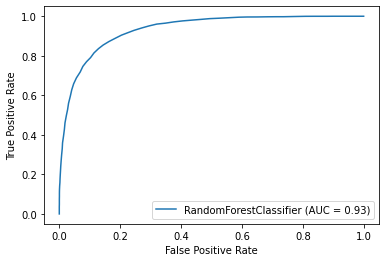

model: Multinomial Naive Bayes
accuracy: 84.88%
tn: 4361, fp: 600, fn: 912, tp: 4127
tn: 87.91%, fp: 12.09%, fn: 18.10%, tp: 81.90%


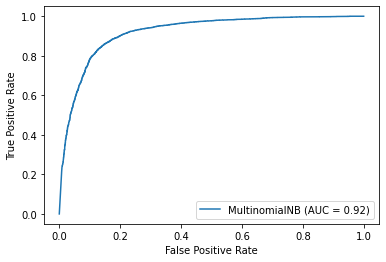

model: Logistic Regression
accuracy: 88.80%
tn: 4362, fp: 599, fn: 521, tp: 4518
tn: 87.93%, fp: 12.07%, fn: 10.34%, tp: 89.66%


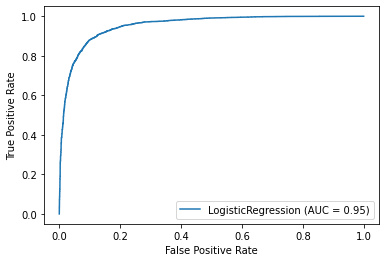

In [ ]:
rf = RandomForestClassifier()
rf_data = test_model(rf, "Random Forest")

mn_m = MultinomialNB()
mn_m_data = test_model(mn_m, "Multinomial Naive Bayes")

lr_m = LogisticRegression(max_iter=15000)
lr_m_data = test_model(lr_m, "Logistic Regression")

<b>the AUC is very similar in all the models, and all of them are very high, but Logistic Regression gained the best result

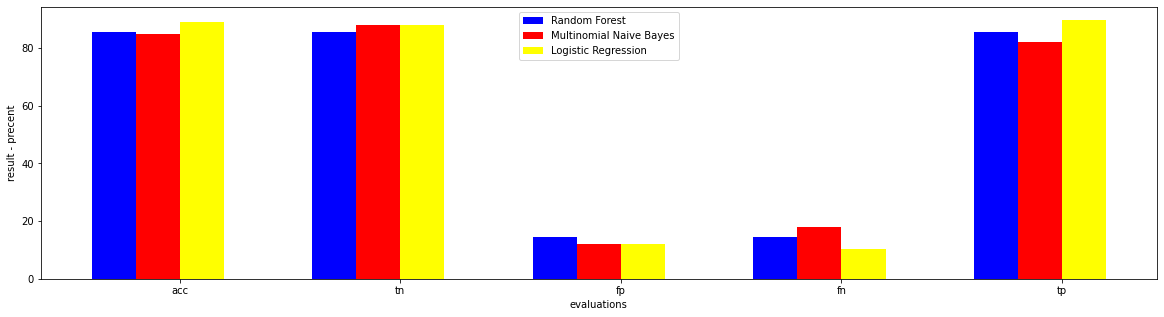

In [ ]:
plt.figure(figsize=(20,5))
x = np.arange(5)
plt.bar(x-0.3, rf_data["results"], 0.2, color='blue')
plt.bar(x-0.1, mn_m_data["results"], 0.2, color='red')
plt.bar(x+0.1, lr_m_data["results"], 0.2, color='yellow')
plt.xticks(x, ["acc","tn","fp","fn","tp"])
plt.xlabel("evaluations")
plt.ylabel("result - precent")
plt.legend(["Random Forest", "Multinomial Naive Bayes", "Logistic Regression"])
plt.show()

<b><h3>conclusion for the first step</h3>

- the best model is Logistic Regression

- the main difference between the errors of Multinomial Naive Bayes and the errors of Logistic Regression model are the false negative

- the worst model in terms of false positive in Random Forest

<b><h3>Second Step:</h3>

test if some changes to the data before using the algorithms will imporve the results:

- clean the data - all the models get the data as B.O.G.. this model understand "good", "good." and "Good" as three different words.  removing special character and turn all text into lowercase will improve the model reabillity.

- using n-gram (1,2) so now the bag of words contains both single words and pairs

- adding new features:

 - counting all the punctuation in review
 
 - sequences:
     - count how many times every sequence (3-5 words) in the trained data occur for every category

     - normelize the results

     - when getting new review, split it to all of its sequences, find their score as described at the previous section and return the highest score


In [ ]:
X_train = X_train_data
X_test = X_test_data

In [ ]:
sequence_2 = dict(positive=dict(), negative=dict())
sequence_3 = dict(positive=dict(), negative=dict())
sequence_4 = dict(positive=dict(), negative=dict())
sequence_5 = dict(positive=dict(), negative=dict())

In [ ]:
def clean_text_cutome_fetures(txt):
    
    # set new line as a word
    txt = re.sub(r'<br />', " enter ", txt)  
    txt =re.sub(r'<br/>', " enter ", txt)

    # remove all other hatml tags
    txt = re.sub(r'<.*?>', ' ', txt)
    
    # set all text as lower case
    txt = txt.strip().lower()
    
    # separate specific characters like punctuation from words for using word base algorithms
    special_chars = '!\/#$%&()*+,-./:;<=>?@[]^_`{|}~'
    special_chars_dict = dict((c, " ") for c in special_chars)
    str_map = str.maketrans(special_chars_dict)
    txt = txt.translate(str_map)

    special_chars = '"'
    special_chars += "'"
    special_chars_dict = dict((c, "") for c in special_chars)

    str_map = str.maketrans(special_chars_dict)
    txt = txt.translate(str_map)
    
    # remove digits and spaces
    stopwords_list = stopwords.words('english')
    stopwords_list.append("enter")
    stopwords_list = [word.replace("'", "").replace('"', "").lower() for word in stopwords_list]
    all_words = [word for word in txt.split(sep = " ") if not word.isdigit() and word not in stopwords_list]
    all_words_not_spaces = filter(lambda item: item, all_words)
    txt = ' '.join(all_words_not_spaces)
    txt = txt.strip()
    
    return txt

In [ ]:
def add_sequence(param, idx, counter, all_words):
    if idx+counter-1 < len(all_words):
        val = " ".join(all_words[idx:idx+counter])
        if val in param:
            param[val] = param[val] + 1
        else:
            param[val] = 1

In [ ]:
def normailze_data(obj):
      df =pd.DataFrame.from_dict(obj, orient='index')
      sort_df = df[df[0] > 3].sort_values(by=0,ascending=False)
      normelized = (( sort_df - sort_df.std() ) / sort_df.mean() )[0].to_dict()
      return normelized

In [ ]:
def set_sequences(corpus, review_type):
    for current_review in corpus:
        txt = clean_text_cutome_fetures(current_review)
        all_words = txt.split()
        for i  in range(len(all_words)):
            add_sequence(sequence_2[review_type], i, 2, all_words)
            add_sequence(sequence_3[review_type], i, 3, all_words)
            add_sequence(sequence_4[review_type], i, 4, all_words)
            add_sequence(sequence_5[review_type], i, 5, all_words)
    sequence_2[review_type] = normailze_data(sequence_2[review_type])
    sequence_3[review_type] = normailze_data(sequence_3[review_type])
    sequence_4[review_type] = normailze_data(sequence_4[review_type])
    sequence_5[review_type] = normailze_data(sequence_5[review_type])        

In [ ]:
def clean_text(txt):
    
    # set new line as a word
    txt = re.sub(r'<br />', " enter ", txt)  
    txt =re.sub(r'<br/>', " enter ", txt)

    # remove all other hatml tags
    txt = re.sub(r'<.*?>', ' ', txt)
    
    # set all text as lower case
    txt = txt.strip().lower()
    
    # separate specific characters like punctuation from words for using word base algorithms
    special_chars = '!"\/#$%&()*+,-./:;<=>?@[]^_`{|}~'
    special_chars_dict = dict((c, " " + c + " ") for c in special_chars)
    str_map = str.maketrans(special_chars_dict)
    txt = txt.translate(str_map)
    
    # remove digits and spaces
    all_words = [word for word in txt.split(sep = " ")]
    all_words_not_spaces = filter(lambda item: item, all_words)
    txt = ' '.join(all_words_not_spaces)
    txt = txt.strip()
    
    return txt

In [ ]:
train_negative_list = list(X_train[X_train["sentiment"]=="negative"]["review"])
set_sequences(train_negative_list, "negative")

train_positive_list = list(X_train[X_train["sentiment"]=="positive"]["review"])
set_sequences(train_positive_list, "positive")

In [ ]:
X_train = X_train["review"]
X_test = X_test["review"]

vectorizer = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    preprocessor=clean_text,
    max_df=0.95,
    min_df=5
)

In [ ]:
def set_row_sequence(data, idx, counter, row, all_words):
    if idx+counter-1 < len(all_words):
        idx_str = str(counter)
        positive_param = "positive_sequence_%s" % (idx_str)
        negative_param = "negative_sequence_%s" % (idx_str)
        ratio_param = "ratio_sequence_%s" % (idx_str)
        val = " ".join(all_words[idx:idx+counter])
        positive_dict = data["positive"]
        negative_dict = data["negative"]
        positive_val = positive_dict[val] if val in positive_dict else 0
        negative_val = negative_dict[val] if val in negative_dict else 0

        row[positive_param] = max(row[positive_param], positive_val)
        row[negative_param] = max(row[negative_param], negative_val)

In [ ]:
def set_new_features(data, df, feature_names):
    rows_data = list()
    
    for txt_item in data:
        row = dict()
        for i in range(3, 6):
            idx_str = str(i)
            row["positive_sequence_%s" % (idx_str)] = 0
            row["negative_sequence_%s" % (idx_str)] = 0
        chars_counter = 0
        space_chars = '!"\/#$%&()*+,-./:;<=>?@[]^_`{|}~'
        for char in space_chars:
            chars_counter = chars_counter + txt_item.count(char)
        row["special_signs"] = chars_counter

        txt = clean_text(txt_item)

        all_words = txt.split()
        for i  in range(len(all_words)):
            set_row_sequence(sequence_3, i, 3, row, all_words)
            set_row_sequence(sequence_4, i, 4, row, all_words)
            set_row_sequence(sequence_5, i, 5, row, all_words)
                
        rows_data.append(row)
        
    new_df = pd.DataFrame(rows_data)
    
    combined = hstack([df, new_df])
    
    if feature_names is not None:
        feature_names.extend(list(new_df.columns))
    
    return combined

In [ ]:
training_features = vectorizer.fit_transform(X_train)
custom_training_features = set_new_features(X_train, training_features, None)
training_features = custom_training_features

custom_features_names = vectorizer.get_feature_names()

test_features = vectorizer.transform(X_test)
custom_test_features = set_new_features(X_test, test_features, custom_features_names)
test_features = custom_test_features

<b>following the above changes:

the reason for printing this curve and its AUC ( the size under the curve ) is for evaluating how much the model is stable.

in addition it will print the other results for every model: 

- accuracy 

- false positive ( the model predict positive but the ground trouth is negative )

- false negative ( the model predict negative but the ground trouth is positive )

- true positive ( the model predict positive and the ground trouth is positive )

- true negative ( the model predict negative and the ground trouth is negative )

in one graph

model: Random Forest
accuracy: 86.29%
tn: 4291, fp: 670, fn: 701, tp: 4338
tn: 86.49%, fp: 13.51%, fn: 13.91%, tp: 86.09%


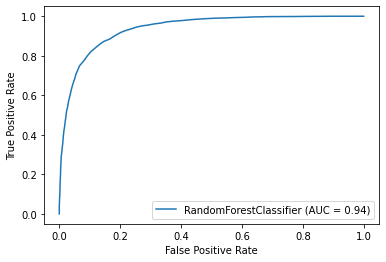

model: Multinomial Naive Bayes
accuracy: 87.51%
tn: 4357, fp: 604, fn: 645, tp: 4394
tn: 87.83%, fp: 12.17%, fn: 12.80%, tp: 87.20%


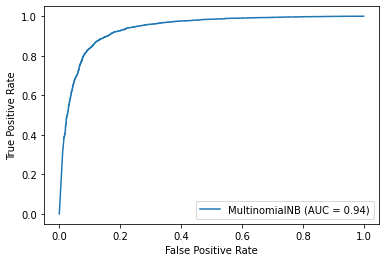

model: Logistic Regression
accuracy: 89.45%
tn: 4409, fp: 552, fn: 503, tp: 4536
tn: 88.87%, fp: 11.13%, fn: 9.98%, tp: 90.02%


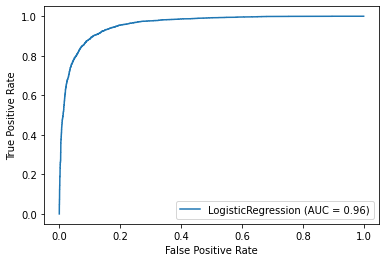

In [ ]:
rf = RandomForestClassifier()
rf_data_new_f = test_model(rf, "Random Forest")

mn_m = MultinomialNB()
mn_m_data_new_f = test_model(mn_m, "Multinomial Naive Bayes")

lr_m = LogisticRegression(max_iter=15000)
lr_m_data_new_f = test_model(lr_m, "Logistic Regression")


<b>the AUC is very similar in all the models, and all of them are very high, but Logistic Regression gained the best result. all the AUC results improved in step two comparing to step one

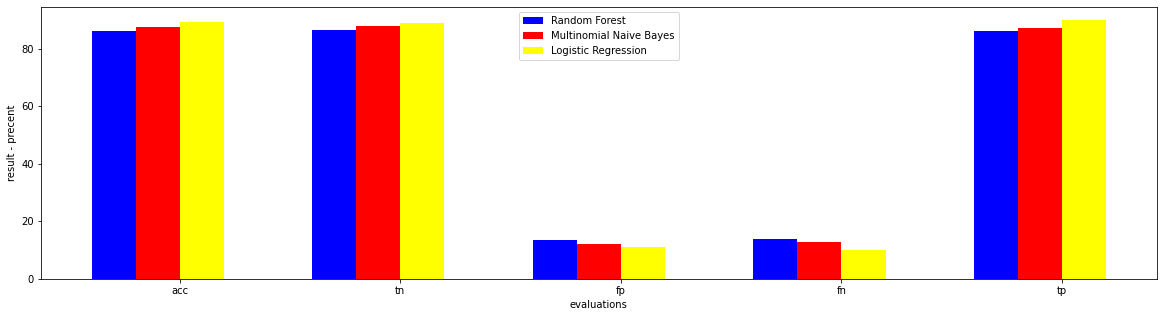

In [ ]:
plt.figure(figsize=(20,5))
x = np.arange(5)
plt.bar(x-0.3, rf_data_new_f["results"], 0.2, color='blue')
plt.bar(x-0.1, mn_m_data_new_f["results"], 0.2, color='red') 
plt.bar(x+0.1, lr_m_data_new_f["results"], 0.2, color='yellow')
plt.xticks(x, ["acc","tn","fp","fn","tp"])
plt.xlabel("evaluations")
plt.ylabel("result - precent")
plt.legend(["Random Forest", "Multinomial Naive Bayes", "Logistic Regression"])
plt.show()

<b><h3>conclusion for the second step</h3>

- all the evaluation results are better, but not by a big difference, all the results of all the model will be displaied in the next table

- in addition the ratio between the Logistic Regression to the Multinomial Naive Bayes in the false positive increased


In [ ]:
pd.DataFrame([{"model": "random forest", "basic": rf_data["results"][0], "custome": rf_data_new_f["results"][0],},
             {"model": "naive bayes", "basic": mn_m_data["results"][0], "custome": mn_m_data_new_f["results"][0]},
            {"model": "logistic classification", "basic": lr_m_data["results"][0], "custome": lr_m_data_new_f["results"][0]}
            ])  

,model,basic,custome
0,random forest,85.51,86.29
1,naive bayes,84.88,87.51
2,logistic classification,88.80,89.45


<b><h3>Third Step:</h3>

exploring the models most important features

<b>the next section will show the 20 most important feature of Random forest and the number of features with not importance at all for this data

num of features with no importance at all is 18954


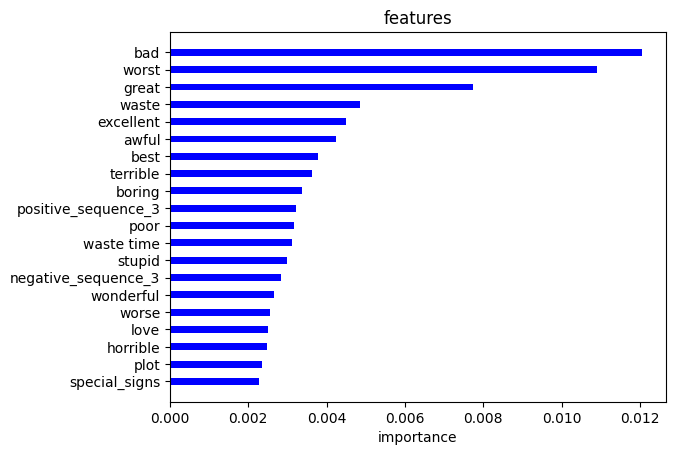

In [ ]:
importances = rf.feature_importances_
feature_names = custom_features_names
rf_data_importance = pd.DataFrame({"word": feature_names, "importance": list(importances)})

best = rf_data_importance.nlargest(20, "importance")
words = list(best["word"])
importance = list(best["importance"])

print("num of features with no importance at all is %s" % (len(rf_data_importance[rf_data_importance["importance"]==0])))

# plt.figure(figsize=(20,5))
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(words))
ax.barh(y_pos, importance, 0.4, color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(words)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('importance')
ax.set_title('features')
plt.show()



<b>positive_sequence_3, negative_sequence_3, special_signs are all custom features

In [ ]:
def set_df_for_graph(df, words):
    df = df.loc[df['word'].isin(words)]
    diff = np.setdiff1d(words, df["word"]).tolist()
    diff_add = [{ "word" : i, "importance": 0 } for i in diff]
    df = df.append(diff_add, ignore_index=True)   
    df = df.sort_values("word", ascending=False, ignore_index=True)
    return df

<b>the next chart will show the most important features of Multinomial Naive Bayes by every category

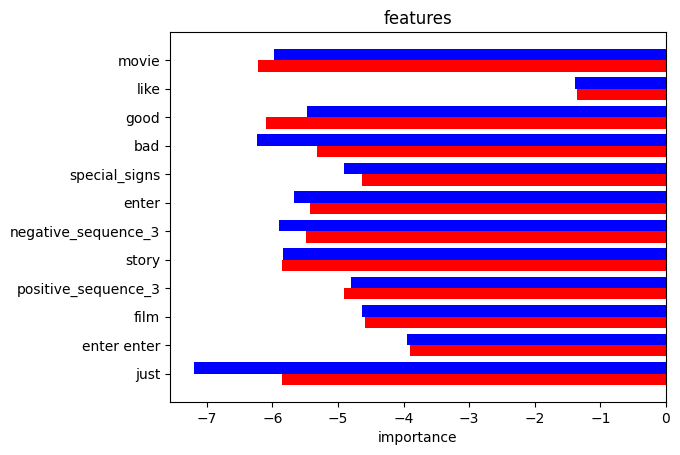

In [ ]:
importances = mn_m.feature_log_prob_
feature_names = custom_features_names

negative = pd.DataFrame({"word": feature_names, "importance": list(importances[0])})
positive = pd.DataFrame({"word": feature_names, "importance": list(importances[1])})

top_positive = positive.nlargest(10, "importance")
names_positive = list(top_positive["word"])

top_negative = negative.nlargest(10, "importance")
names_negative = list(top_negative["word"])

words = list(set(names_positive + names_negative))

top_negative = set_df_for_graph(negative, words)
top_positive = set_df_for_graph(positive, words)

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(words))
ax.barh(y_pos-0.2, list(top_positive.loc[:,"importance"]), 0.4, color='blue')
ax.barh(y_pos+0.2, list(top_negative.loc[:,"importance"]), 0.4, color='red')
ax.set_yticks(y_pos)
ax.set_yticklabels(words)
ax.invert_yaxis() 
ax.set_xlabel('importance')
ax.set_title('features')
plt.show()


<b><span/>
1. positive_sequence_3, negative_sequence_3, special_signs are all custom features

2. enter enter - n-gram(1,2)

<b>the next chart will show the most important features of Logistic Regression

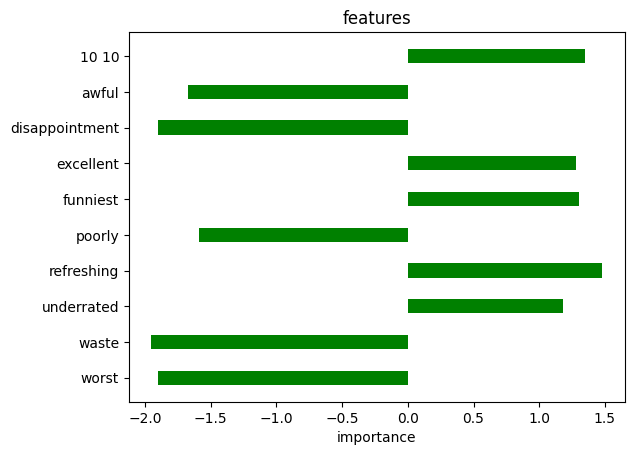

In [ ]:
feature_names = custom_features_names
lr_data_importance = pd.DataFrame({"word": feature_names, "importance": list(lr_m.coef_[0])})

largest_importance = lr_data_importance.nlargest(5, "importance")
smallest_importance = lr_data_importance.nsmallest(5, "importance")


words = list(set(list(largest_importance["word"]) + list(smallest_importance["word"])))

lr_data_importance = lr_data_importance.loc[lr_data_importance['word'].isin(words)]

plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(words))
ax.barh(y_pos, list(lr_data_importance.loc[:,"importance"]), 0.4, color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(lr_data_importance.loc[:,"word"])
ax.invert_yaxis()  
ax.set_xlabel('importance')
ax.set_title('features')
plt.show()

<b><h3>conclusion for the third step</h3>

- random forest - three of the new features are in the top 20 important features. out of all the sequences features only _ 3 are in the among the most important features.

- naive bayes - three of the new fetures are in the top 12 imoprtant feature. 

- logistic regression - no new features is in the most important features. but one pair is in the top 10 and it happen because now the model uses n-gram (1,2)

all the model gained better result following the changes